# Gerenciamento de Bibliotecas

In [1]:
%%capture
!pip install -U scikit-learn
!pip install nltk
!pip install deep-translator
!pip install datasets
!pip install ace-tools-open

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import nltk
from nltk.corpus import stopwords
import string
import requests
from bs4 import BeautifulSoup
from deep_translator import GoogleTranslator
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch

# Importação e Preparação dos Dados

**Referência do Dataset**

O conjunto de dados utilizado neste projeto está disponível no Kaggle:

**Título do Dataset:** Website Classification  
**Autor:** Hetul Mehta  
**Ano de publicação:** 2024  
**Licença:** CC0: Public Domain  
**Link:** https://www.kaggle.com/datasets/hetulmehta/website-classification

---

Mehta, Hetul. (2024). *Website Classification*. Disponível no Kaggle: [https://www.kaggle.com/datasets/hetulmehta/website-classification](https://www.kaggle.com/datasets/hetulmehta/website-classification). Licença: CC0: Public Domain. Acesso em: 06 de março de 2025.

---

In [85]:
# Upload do Dataset
from google.colab import files
_ = files.upload()

Saving website_classification.zip to website_classification.zip


In [86]:
!unzip "/content/website_classification" -d "/content/"

Archive:  /content/website_classification.zip
  inflating: /content/website_classification.csv  


In [4]:
file_path = "/content/website_classification.csv"

sns.set(style="whitegrid", font_scale=1.1)

df = pd.read_csv(file_path, index_col=0)

# Exibe as primeiras linhas e informações gerais
print("Primeiras linhas do dataset:")
display(df.head())

Primeiras linhas do dataset:


,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [5]:
print("Estatísticas descritivas:")
display(df.describe(include='all'))

Estatísticas descritivas:


,website_url,cleaned_website_text,Category
count,1408,1408,1408
unique,1384,1375,16
top,https://carehospitals.com/,good multispecialty hospital hyderabad india c...,Education
freq,4,4,114


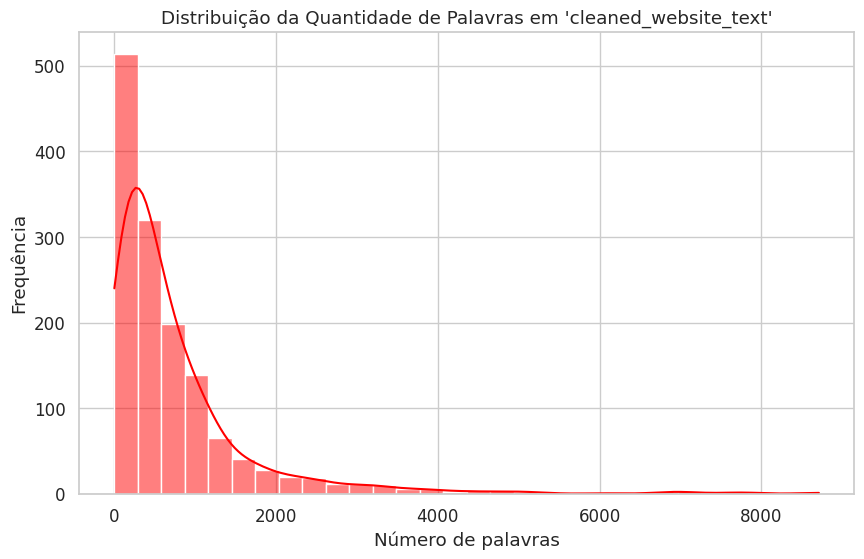

In [7]:
df['word_count'] = df['cleaned_website_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, kde=True, color='red')
plt.title("Distribuição da Quantidade de Palavras em 'cleaned_website_text'")
plt.xlabel("Número de palavras")
plt.ylabel("Frequência")
plt.show()

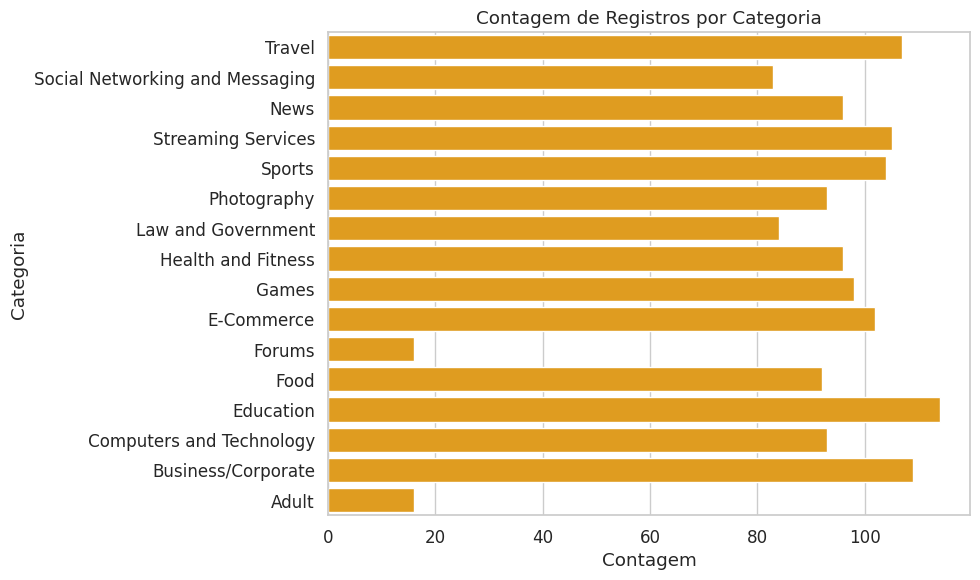

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df, color='Orange')
plt.title("Contagem de Registros por Categoria")
plt.xlabel("Contagem")
plt.ylabel("Categoria")
plt.tight_layout()
plt.show()

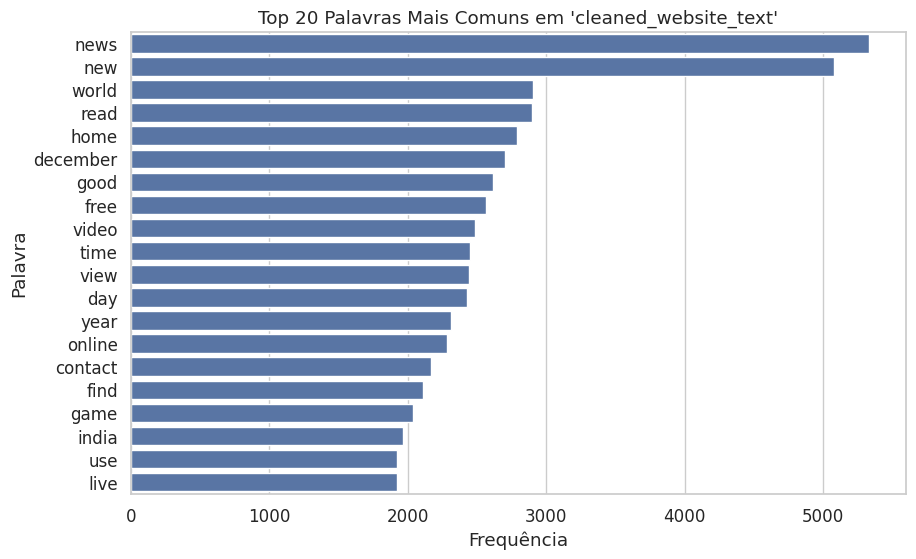

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

all_text = " ".join(df['cleaned_website_text'].dropna().astype(str).apply(clean_text))
words = all_text.split()
word_counts = Counter(words)

most_common = word_counts.most_common(20)
common_words, common_counts = zip(*most_common)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(common_counts), y=list(common_words))
plt.title("Top 20 Palavras Mais Comuns em 'cleaned_website_text'")
plt.xlabel("Frequência")
plt.ylabel("Palavra")
plt.show()

# Treinamento do modelo Naive Bayes

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

X = df["cleaned_website_text"]
y = df["Category"]

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [11]:
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)

MultinomialNB()

In [12]:
y_predict = model_NB.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
classif_report_dict = classification_report(y_test, y_predict, output_dict=True)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
overall_stats = {
    "Accuracy": classif_report_dict["accuracy"],
    "Macro Precision": classif_report_dict["macro avg"]["precision"],
    "Macro Recall": classif_report_dict["macro avg"]["recall"],
    "Macro F1-Score": classif_report_dict["macro avg"]["f1-score"],
    "Weighted Precision": classif_report_dict["weighted avg"]["precision"],
}

NB_stats_df = pd.DataFrame([overall_stats])

from IPython.display import display
display(NB_stats_df)

,Accuracy,Macro Precision,Macro Recall,Macro F1-Score,Weighted Precision
0,0.897163,0.792884,0.803725,0.792466,0.894907


In [14]:
class_labels = [label for label in classif_report_dict.keys() if label not in ["accuracy", "macro avg", "weighted avg"]]

In [15]:
precision_by_class = [classif_report_dict[label]['precision']for label in class_labels]
recall_by_class = [classif_report_dict[label]['recall']for label in class_labels]
f1_score_by_class = [classif_report_dict[label]['f1-score']for label in class_labels]

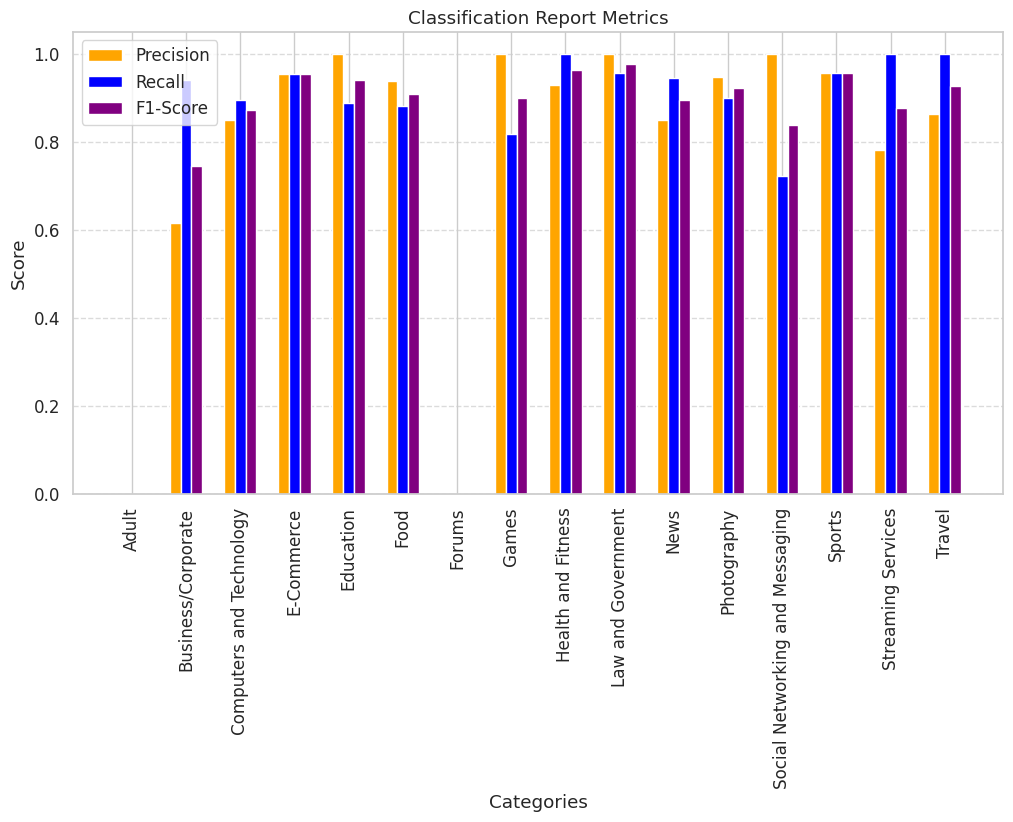

In [16]:
x = np.arange(len(class_labels))
width = 0.20

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision_by_class, width, label='Precision', color='orange')
plt.bar(x, recall_by_class, width, label='Recall', color='blue')
plt.bar(x + width, f1_score_by_class, width, label='F1-Score', color='purple')

plt.xlabel("Categories")
plt.ylabel("Score")
plt.title("Classification Report Metrics")
plt.xticks(ticks=x, labels=class_labels, rotation=90)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# Treinamento do modelo Bert(pretrained)

In [17]:
file_path = "/content/website_classification.csv"
df = pd.read_csv(file_path, index_col=0)

In [18]:
label_encoder = LabelEncoder()

df['labels'] = label_encoder.fit_transform(df['Category'])
df = df.dropna(subset=['cleaned_website_text', 'labels'])

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    tokens = tokenizer(
        examples["cleaned_website_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokens["labels"] = examples["labels"]
    return tokens

dataset = Dataset.from_pandas(df[['cleaned_website_text', 'labels']])
dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(["cleaned_website_text"])
dataset = dataset.remove_columns(["__index_level_0__"]) if "__index_level_0__" in dataset.column_names else dataset


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [19]:
valid_columns = ["labels", "input_ids", "attention_mask", "token_type_ids"]
unwanted_columns = [col for col in dataset.column_names if col not in valid_columns]
if unwanted_columns:
    dataset = dataset.remove_columns(unwanted_columns)

In [20]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    classif_report = classification_report(labels, preds, output_dict=True)

    return {
        "accuracy": classif_report["accuracy"],
        "macro_precision": classif_report["macro avg"]["precision"],
        "macro_recall": classif_report["macro avg"]["recall"],
        "macro_f1": classif_report["macro avg"]["f1-score"],
    }

In [21]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=5e-05,
    seed=21,
    report_to="none",
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,0.580907,0.886525,0.774183,0.796564,0.782187
2,No log,0.384779,0.911348,0.854426,0.865732,0.858022
3,No log,0.290292,0.932624,0.876120,0.887686,0.879897
4,0.627700,0.393959,0.921986,0.867446,0.874525,0.869442
5,0.627700,0.377029,0.925532,0.868098,0.877501,0.871466


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=705, training_loss=0.4636116947688109, metrics={'train_runtime': 649.4635, 'train_samples_per_second': 8.669, 'train_steps_per_second': 1.086, 'total_flos': 1481501443522560.0, 'train_loss': 0.4636116947688109, 'epoch': 5.0})

In [23]:
%%capture
overall_bert = trainer.evaluate()
bert_metrics_df = pd.DataFrame([overall_bert])

In [24]:
bert_metrics_df

,eval_loss,eval_accuracy,eval_macro_precision,eval_macro_recall,eval_macro_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.377029,0.925532,0.868098,0.877501,0.871466,8.3495,33.774,4.312,5.0


In [25]:
%%capture
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = predictions.label_ids

class_labels = label_encoder.classes_

report_dict = classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    output_dict=True
)

precision_values = [report_dict[label]['precision'] for label in class_labels]
recall_values = [report_dict[label]['recall'] for label in class_labels]
f1_values = [report_dict[label]['f1-score'] for label in class_labels]

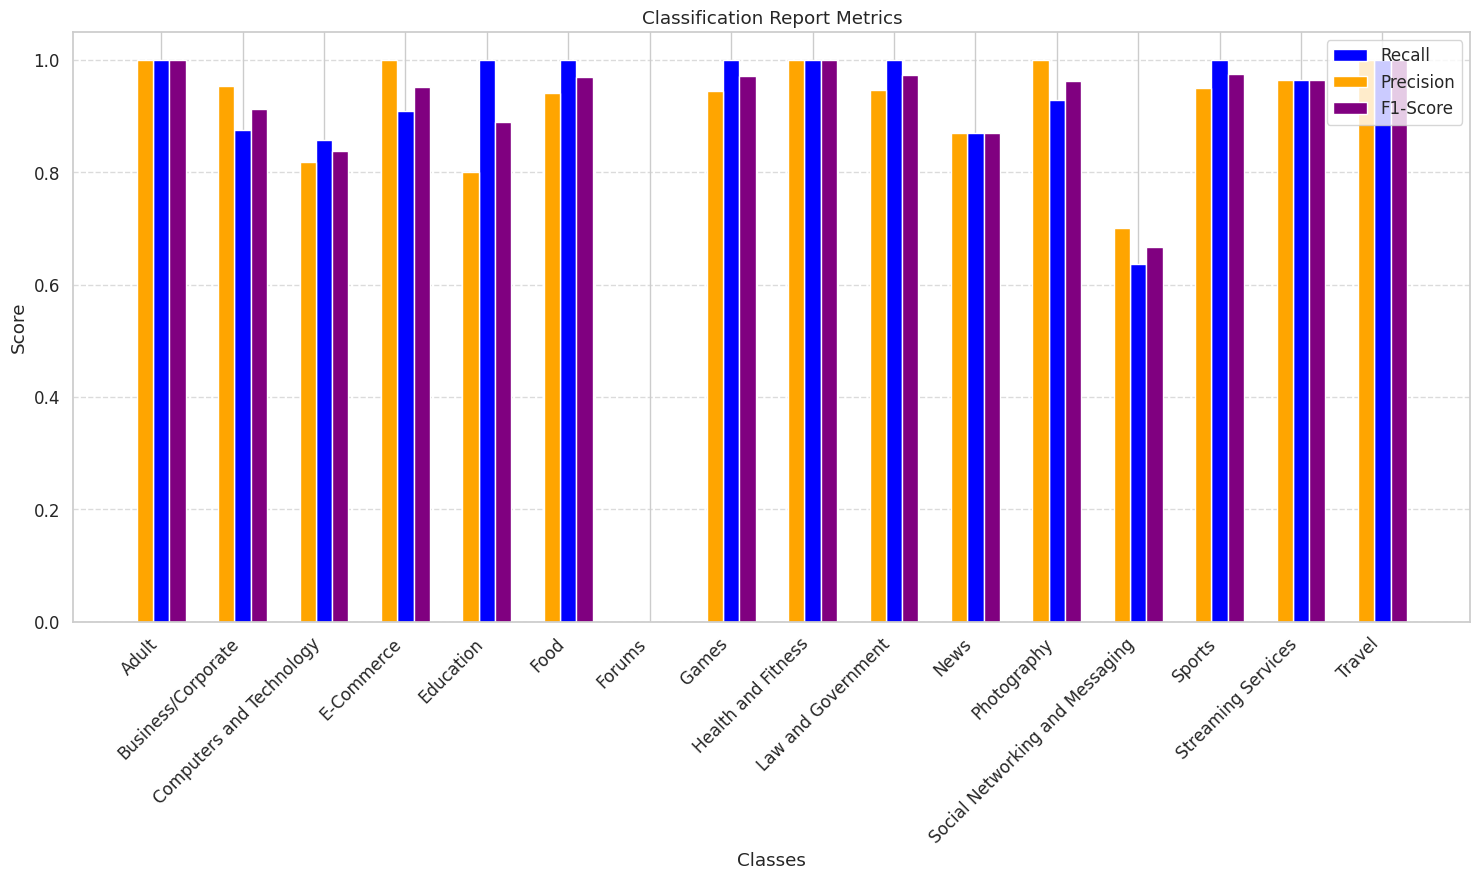

In [26]:
x = np.arange(len(class_labels))
width = 0.2

plt.figure(figsize=(15, 9))

plt.bar(x, recall_values, width, label='Recall', color='blue')
plt.bar(x - width, precision_values, width, label='Precision', color='orange')
plt.bar(x + width, f1_values, width, label='F1-Score', color='purple')

plt.xlabel("Classes")
plt.ylabel("Score")
plt.title("Classification Report Metrics")
plt.xticks(ticks=x, labels=class_labels, rotation=45, ha='right')
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
model.save_pretrained('bert_web_classification')
tokenizer.save_pretrained('bert_web_classification')

('bert_web_classification/tokenizer_config.json',
 'bert_web_classification/special_tokens_map.json',
 'bert_web_classification/vocab.txt',
 'bert_web_classification/added_tokens.json')

# Avaliação dos Resultados



In [65]:
selected_metrics_df = bert_metrics_df[['eval_accuracy', 'eval_macro_recall', 'eval_macro_f1', 'eval_macro_precision']]
selected_metrics_df_NB = NB_stats_df[['Accuracy', 'Macro Recall', 'Macro F1-Score', 'Macro Precision']]

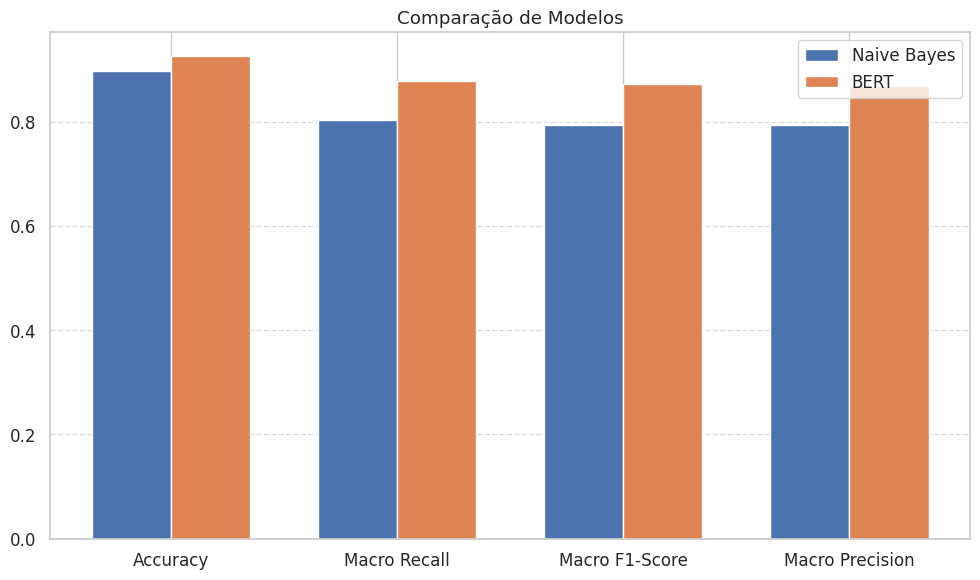

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Macro Recall', 'Macro F1-Score', 'Macro Precision']
bert_scores = selected_metrics_df.iloc[0].values
nb_scores = selected_metrics_df_NB.iloc[0].values

x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, nb_scores, width, label='Naive Bayes')
ax.bar(x + width/2, bert_scores, width, label='BERT')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_title('Comparação de Modelos')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
# Funções de pré-processamento

nltk.download('stopwords')

def remove_stopwords(text):
  stop_words = set(stopwords.words('portuguese'))
  words = text.lower().translate(str.maketrans('', '', string.punctuation)).split()
  filtered_text = [word for word in words if word not in stop_words]
  cleaned_text = ' '.join(filtered_text)
  return cleaned_text


def translate_text(text, source='auto', target='en'):
    translator = GoogleTranslator(source=source, target=target)
    max_chars = 4999
    chunks = [text[i:i+max_chars] for i in range(0, len(text), max_chars)]
    translated_text = ' '.join([translator.translate(chunk) for chunk in chunks])
    return translated_text


def get_clean_text_from_url(url):
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        for script in soup(['script', 'style']):
            script.extract()
        text = soup.get_text()
        text = ' '.join(text.split())
        return text
    except Exception as e:
        return f"Erro ao processar a URL: {str(e)}"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# Inferência em modelos

def inferencia_naive_bayes(cleaned_text):
  text_tfidf = vectorizer.transform([cleaned_text])
  prediction = model_NB.predict(text_tfidf)[0]
  return prediction

def inferencia_bert(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_id = torch.argmax(logits, dim=1).item()
    predicted_label = label_encoder.inverse_transform([predicted_id])[0]
    return predicted_label

In [36]:
def classify_website(url):
    clean_text = get_clean_text_from_url(url)
    if clean_text.startswith("Erro") or not clean_text:
        return {"url": url, "error": clean_text}

    translated = translate_text(clean_text, source='auto', target='en')
    lower_text = translated.lower()
    cleaned_text = remove_stopwords(lower_text)

    print(f"Url: {url} Categoria: {urls_to_tests[url]}")

    NB_result = inferencia_naive_bayes(cleaned_text)
    print(f"Modelo Naive Bayes - Categoria prevista: {NB_result}")

    model = BertForSequenceClassification.from_pretrained('bert_web_classification')
    tokenizer = BertTokenizer.from_pretrained('bert_web_classification')
    BERT_result = inferencia_bert(model, tokenizer, cleaned_text)
    print(f"Modelo BERT - Categoria prevista: {BERT_result}")

    return {
        "url": url,
        "categoria_real": urls_to_tests[url],
        "categoria_naive_bayes": NB_result,
        "categoria_bert": BERT_result
    }

In [55]:
urls_to_tests = {
    "https://g1.globo.com/": "News",
    "https://www.unimed.coop.br/site/": "Health and Fitness",
    "https://www.arpoadorgastronomiaelazer.com/": "Food",
    "https://www.dust2.com.br/": "Sports",
    "https://www.clubedohardware.com.br/": "Computers and Technology",
    "https://www.mercadolivre.com.br/": "E-Commerce",
    "https://www.gov.br/pt-br": "Law and Government",
    "https://www.pulsarimagens.com.br/": "Photography"
}

resultados = []
for url in urls_to_tests:
    print(f"-"*42)
    resultado = classify_website(url)
    resultados.append(resultado)

------------------------------------------
Url: https://g1.globo.com/ Categoria: News
Modelo Naive Bayes - Categoria prevista: News
Modelo BERT - Categoria prevista: News
------------------------------------------
Url: https://www.unimed.coop.br/site/ Categoria: Health and Fitness
Modelo Naive Bayes - Categoria prevista: Health and Fitness
Modelo BERT - Categoria prevista: Health and Fitness
------------------------------------------
Url: https://www.arpoadorgastronomiaelazer.com/ Categoria: Food
Modelo Naive Bayes - Categoria prevista: Food
Modelo BERT - Categoria prevista: Food
------------------------------------------
Url: https://www.dust2.com.br/ Categoria: Sports
Modelo Naive Bayes - Categoria prevista: Sports
Modelo BERT - Categoria prevista: Sports
------------------------------------------
Url: https://www.clubedohardware.com.br/ Categoria: Computers and Technology
Modelo Naive Bayes - Categoria prevista: Streaming Services
Modelo BERT - Categoria prevista: Computers and Tech

In [60]:
# Matriz de Comparação de Classificação
df = pd.DataFrame(resultados)

def marcar_acerto(previsto, real):
    if real:
        return "✔" if previsto == real else "✖"
    return "-"

df["naive_bayes"] = df.apply(lambda row: marcar_acerto(row["categoria_naive_bayes"], row["categoria_real"]), axis=1)
df["bert"] = df.apply(lambda row: marcar_acerto(row["categoria_bert"], row["categoria_real"]), axis=1)

df_resultados = df.set_index("url")[["naive_bayes", "bert"]]


In [61]:
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Matriz de Comparação de Classificação", dataframe=df_resultados)

Matriz de Comparação de Classificação


# Conclusões

- O modelo BERT superou o modelo Naive Bayes em todas as métricas avaliadas (acurácia, precisão, recall, F1-score).
- Observou-se maior custo computacional com BERT devido ao tamanho do input (512 tokens), sugerindo testes futuros com tamanhos menores.
- O pré-processamento mostrou-se essencial para o bom desempenho da classificação.
- Possíveis melhorias futuras incluem ajuste fino do BERT, testes com outras arquiteturas, data augmentation para classes menos representadas no dataset e uma análise qualitativa dos erros encontrados.